In [1]:
import pandas as pd # handle tabular data
import networkx as nx # handle network data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data into dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kanji_with_bert_embeddings_null.csv')

In [4]:
# convert embeddings from strings to list of numbers
df['bert_float'] = df.bert_small_embeddings.apply(lambda s: [float(x) for x in s.replace('[','').replace(']','').replace("''",'').split()])

In [5]:
from scipy.spatial.distance import cosine

# compute cosine similarity between all embeddings
cos = dict()
for i, x in enumerate(df.bert_float):
    for j, y in enumerate(df.bert_float):
        if x != y:
            edge = (df.iloc[i]['kanji'], df.iloc[j]['kanji'])
            cos[edge] = cosine(x,y)

In [6]:
# a shorthand to easily get the classification for all kanjis
attrs = dict()
for i, attr in enumerate(df.kanji_classification):
    attrs[df.iloc[i]['kanji']] = ''.join(attr.split()[1:])

In [7]:
# create network based on minimum similarity between embeddings
minimum_similarity = 0.35
g = nx.Graph()
for e in cos:
    if not g.has_edge(*e):
        if cos[e] >= minimum_similarity:
            g.add_edge(*e, weight=cos[e])
nx.set_node_attributes(g, attrs, 'classification')

## Network Structure Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
def network_statistics(g):
    print(f'Number of nodes: {g.number_of_nodes()}')
    print(f'Number of edges: {g.number_of_edges()}')
    print(f'Density: {round(nx.density(g), 3)}')
    print(f'Average Clustering Coefficient: {round(nx.average_clustering(g), 3)}')
    print(f'Connected components: {nx.number_connected_components(g)}')
    lcc = max(nx.connected_components(g), key=len)
    print(f'Size largest connected component: {len(lcc)}')
    print(f'Diameter: {nx.diameter(nx.subgraph(g, lcc))}')
    print(f'Average Shortest Path: {round(nx.average_shortest_path_length(g), 3)}')

def plot_degree_dist(g):
    plt.title('Degree distribution')
    degree_freq = nx.degree_histogram(g)
    degrees = range(len(degree_freq))
    plt.loglog(degrees, degree_freq,'.') 
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()
    
def plot_weights_dist(g):
    weights = nx.get_edge_attributes(g, 'weight')
    plt.title('Cosine Similarity distribution')
    sns.kdeplot(data=weights.values(), label='weight')
    plt.show()
    
def get_top(measure, top=10):
    """
    returns the top ten elements according to the measures param
    """
    ranks = [(k, v) for k, v in sorted(measure.items(), key=lambda item: -item[1])]
    return ranks[:top]


In [9]:
network_statistics(g)

Number of nodes: 268
Number of edges: 488
Density: 0.014
Average Clustering Coefficient: 0.0
Connected components: 1
Size largest connected component: 268
Diameter: 5
Average Shortest Path: 2.138


The graph is large with almost 1000 nodes. As with most real networks, this results in very sparse (i.e., not dense) connections. There is only one connected component, meaning that it is possible to reach every node from every other node in the network. Each node is on average 2.1 steps away from any other, and at most 5 steps.

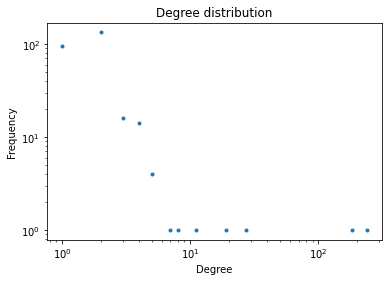

In [10]:
plot_degree_dist(g)

Most nodes have very few connections (left), while very few nodes account for most of the network connectivity (right). This is likely due to few hubs that connect most of the network.

In [11]:
print('Most connected kanjis:')
for char, d in get_top(dict(g.degree())):
    print(char, d)

Most connected kanjis:
道 238
村 182
湖 27
車 19
北 11
当 8
早 7
恐 5
今 5
聞 5


Indeed, the first two kanjis connect the majority of the network

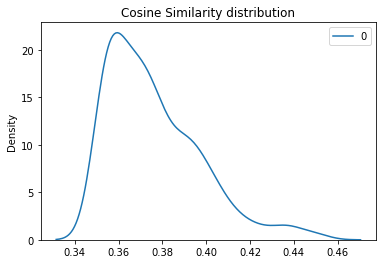

In [12]:
plot_weights_dist(g)

Most of the kanjis have a similarity of abut 0.35, but few also reach up to 0.5

In [13]:
weights = nx.get_edge_attributes(g, 'weight')
print('Closest kanjis w.r.t. cosine similarity:')
for chars, w in get_top(weights):
    print(chars, round(w, 5))

Closest kanjis w.r.t. cosine similarity:
('道', '早') 0.45189
('村', '早') 0.45098
('道', '恐') 0.44953
('道', '当') 0.44766
('村', '当') 0.44193
('道', '驚') 0.44175
('道', '急') 0.44142
('道', '空') 0.4385
('村', '堅') 0.43786
('村', '硬') 0.43786


In [14]:
print('Farthest kanjis w.r.t. cosine similarity:')
top = 10
for chars, w in [(k, v) for k, v in sorted(weights.items(), key=lambda item: item[1])][:top]:
    print(chars, round(w, 5))

Farthest kanjis w.r.t. cosine similarity:
('道', '力') 0.35005
('湖', '騒') 0.3504
('村', '外') 0.35041
('道', '神') 0.35054
('村', '舞') 0.35059
('村', '刻') 0.35064
('車', '考') 0.35066
('道', '板') 0.35073
('村', '次') 0.35074
('荒', '北') 0.35082


(maximal) cliques are sets of nodes that are all connected to each other. i.e. , if (A,B,C,D) is a clique, then all of the following edges exist: AB, BC, CD DA, BD AC

In [15]:
with open('cliques.txt', 'a') as f:
    for clq in nx.find_cliques(g):
        if len(clq) > 2:
            f.write(str(clq) + '\n\n')

Eigenvector centrality can be used to identify the most important nodes in a network. 

In [16]:
eigen = nx.eigenvector_centrality(g, max_iter=5000)
for n, value in get_top(eigen):
    print(n, round(value, 3))


道 0.535
村 0.452
湖 0.077
当 0.06
早 0.059
恐 0.058
艶 0.057
急 0.057
空 0.057
堅 0.057


## Community Analysis
To identify communities we leverage <code>cdlib</code>, a python library specifically designed to work with community detection

In [17]:
!pip install cdlib
!pip install leidenalg
from cdlib import algorithms, viz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 KB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 66.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.6 MB/s eta 0:00:00
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=5d3df153ff92c65a4ebaa668fd681cdbfa3eca43b89c01ee49114c56e7bc89c3
  Stored in directory: /root/.cache/pip/wheels/e0/56/c2/abb6866a3fcd8a55862f1df8a18f57805c3a7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'karateclub', 'infomap', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


First, we need to convert nodes to integers. We also leave a <code>from_int_to_kanjis</code> mapping.

In [18]:
g_int = nx.convert_node_labels_to_integers(g, label_attribute='kanji')
from_int_to_kanjis = dict(g_int.nodes('kanji'))

We will use the well known Leiden algorithm to identify tightly knit communities. Evaluation is performed via the Newman modularity, a measure that quantifies the community density

In [19]:
coms = algorithms.leiden(g_int)
coms.newman_girvan_modularity().score

0.2250661439498973

In [20]:
print('The leiden algorithm identified', len(coms.communities), 'communities')

The leiden algorithm identified 4 communities


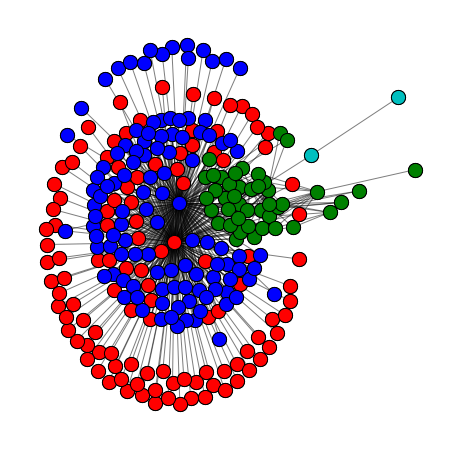

In [21]:
viz.plot_network_clusters(g_int, coms)

In [22]:
with open('coms-leiden.txt', 'a') as f:
    for com in coms.communities:
        f.write(str([from_int_to_kanjis[n] for n in com]) + '\n\n')

Here we also leverage EVA, another algorithm that tries to find tightly knit communities while mantaining attribute similarity. We try to find tightly knit communities that are also homogeneous w.r.t. the classification attribute

In [23]:
labels = {n:{'classification': v} for n,v in nx.get_node_attributes(g_int, 'classification').items()}
coms2 = algorithms.eva(g_int, labels=labels, alpha=0.3)
coms2.newman_girvan_modularity().score

0.2080763096162229

In [24]:
print('The EVA algorithm identified', len(coms2.communities), 'communities')

The EVA algorithm identified 41 communities


<AxesSubplot:title={'center':'EVA communities size distribution'}, ylabel='Density'>

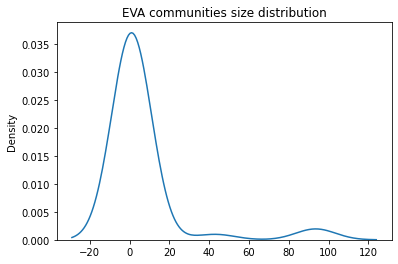

In [25]:
plt.title('EVA communities size distribution')
sns.kdeplot([len(c) for c in coms2.communities])

We only save communities of size > 50

In [26]:
with open('coms-eva.txt', 'a') as f:
    for com in coms2.communities:
        if len(com) > 1:
            f.write(str([from_int_to_kanjis[n] for n in com]) + '\n\n')

In [27]:
nx.write_gexf(g, "kanji.gexf")